<a href="https://colab.research.google.com/github/shafiurrahman/nlp_toxic_commentclassification/blob/main/submission_toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

#set random seed for the session
random.seed(1)
np.random.seed(1)

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-69768a4e-f50b-b9c8-a821-29a210f3e53a)


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/stats/train_toxic.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.info()
train[train["toxic"]==1]

In [ ]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
X=train['comment_text']
y=pd.get_dummies(train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]).values

In [ ]:
df_counts = train.drop(['id', 'comment_text'], axis = 1)
label_counts = y.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts

,counts
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


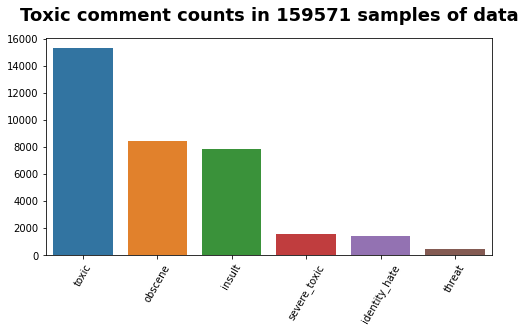

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8,4))
p = sns.barplot(df_counts.index, df_counts['counts'])
x = plt.xticks(rotation = 60) 
ax.set_title('Toxic comment counts in '+ str(len(train))+ ' samples of data', weight = 'bold', fontsize = 18, y = 1.05)
x = ax.set_ylabel('')

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((127656,), (31915,), (127656, 6), (31915, 6))

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def clean_sentences(train):
    reviews = []

    for sent in tqdm(train):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove special characters and numbers
        review_text = re.sub("[^a-zA-Z]+"," ", review_text)#missed out 0-9
        
       # review_text = re.sub("[0-9-~`!@#$%^&*()?:;..'' ``,<>]"," ", review_text)
    
    
        #tokenize the sentences using nltk word_tokenize--this is differrent from tokenizer of tensorflow
        words = word_tokenize(review_text.lower())
    
        #stop words removal
        omit_words = set(stopwords.words('english'))
        words = [x for x in words if x not in omit_words]
        
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(X_train)
test_sentences = clean_sentences(X_test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 31915/31915 [00:33<00:00, 953.86it/s]

127656
31915


In [ ]:
#target=train.Sentiment.values

# Set values for various parameters of word2vec
num_features = 200  # Word vector dimensionality. Determines the no of words each word in the vocabulary will
#be associated with. Must be tuned.
min_word_count = 5   # Minimum word count. Words occuring below the threshold will be ignored
num_workers = 1       # Number of threads to run in parallel
context = 5         # Context window size to be considered for each word                                             
downsampling = 1e-3 

In [ ]:
from gensim.models import word2vec

#Model Word2Vec
model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If the model is not going to be trained further, init_sims can be called 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [ ]:
model.wv.index2word[3]

'talk'

In [ ]:
print("the three most common words")
print(model.wv.index2word[0], model.wv.index2word[1], model.wv.index2word[2], model.wv.index2word[3])

the three most common words
article page wikipedia talk


In [ ]:
def createFeatureVector(words, model, num_features):
    #initialize a 1D array with length as num of features of word2vec model chosen by us. 
    #Here it is 200.
    featVector = np.zeros((num_features,),dtype="float32")
    
    nWords = 0
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, as set is faster
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word and add it to the feature vector to get the total sum of feature vectors of the
    #entire review
    for word in words:
        if word in index2word_set: 
            nWords = nWords + 1.
            featVector = np.add(featVector,model[word])
            
    # Divide the result by the number of words to get the average of the feature vectors of 
    #all words in the review
    if(nWords != 0):
        featVector = np.divide(featVector,nWords)
    return featVector

#calculates the average of the feature vectors for each review using the word2vec values assigned for 
#each word
def avgFeatureVectors(sentences, model, num_features):
    overallFeatureVectors = []
    for sentence in tqdm(sentences):
        overallFeatureVectors.append(createFeatureVector(sentence, model, num_features)) 
    return overallFeatureVectors

train_vect = avgFeatureVectors( train_sentences, model, num_features )
test_vect = avgFeatureVectors( test_sentences, model, num_features )

100%|██████████| 31915/31915 [01:59<00:00, 267.01it/s]


In [ ]:
train_vect
test_vect

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50
x_train = pad_sequences(train_vect, maxlen = maxlen,padding='post',dtype='float64')
x_test = pad_sequences(test_vect, maxlen = maxlen,padding='post',dtype='float64')
max_feature = 10000

In [ ]:
np.all (x_test==x_test[0])
np.all (x_train==x_train[0])# checking whether padding all same values as first number happens when it can makke all numbers 0
#np.all(y_train==y_train[0])

False

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
input = Input(shape = (maxlen,))
embed_size = 128
x = Embedding(max_feature, embed_size)(input)
x = LSTM(60, return_sequences = True, name = "lstm_layer")(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation = "relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation = "sigmoid")(x)


In [ ]:
model1 = Model(inputs = input, outputs = x)
model1.compile(loss = "binary_crossentropy",
             optimizer = "adam",
             metrics = ["accuracy"])
print(model1.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 128)           1280000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 50, 60)            45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [ ]:
batch_size = 32
epochs = 2
history=model1.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

Epoch 1/2
3591/3591 [==============================] - 30s 7ms/step - loss: 0.1467 - accuracy: 0.8984 - val_loss: 0.1468 - val_accuracy: 0.9940
Epoch 2/2
3591/3591 [==============================] - 24s 7ms/step - loss: 0.1424 - accuracy: 0.9922 - val_loss: 0.1464 - val_accuracy: 0.9940


In [ ]:
y_pred = model1.predict(x_test,batch_size=32)
y_pred

In [ ]:
score = model1.evaluate(x_test, y_pred, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 4s 4ms/step - loss: 0.1333 - accuracy: 1.0000
Test Score: 0.13327069580554962
Test Accuracy: 1.0


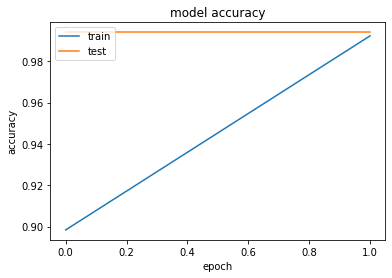

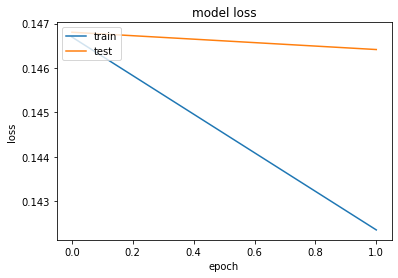

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

##multi layer perceptron

In [ ]:
x_train_mlp=x_train[:122531]
y_train_mlp=y_train[:122531]
x_train_mlp.shape,y_train_mlp.shape


((122531, 50), (122531, 6))

In [ ]:
from sklearn.neural_network import MLPClassifier#multi layer perceptron

mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train_mlp, y_train_mlp) 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['ta

In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
y_pred=clf.predict(x_test)
#y_pred_mlp=y_pred_mlp[:122531]
y_pred
#y_pred_mlp==y_pred_mlp[0]

In [ ]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
score = accuracy_score(y_test,y_pred)
print(score)

0.9060629797900673


In [ ]:
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_test, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.81      0.55      0.65      3056
           1       0.00      0.00      0.00       321
           2       0.80      0.51      0.62      1715
           3       0.00      0.00      0.00        74
           4       0.73      0.46      0.57      1614
           5       0.00      0.00      0.00       294

   micro avg       0.79      0.46      0.58      7074
   macro avg       0.39      0.25      0.31      7074
weighted avg       0.71      0.46      0.56      7074
 samples avg       0.05      0.04      0.04      7074



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Model RF
model_rf = RandomForestClassifier(random_state=1, n_estimators=500, verbose=1, n_jobs=-1, oob_score=True)
model_rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=1,
                       warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# the score for the trained model. Here it is around 62%. It can be further increased, by fine-tuning
#word2vec model as well as rf model using possibly grid search.
result = model_rf.predict( x_test )
score = accuracy_score(y_test,result)
print(score)
print (classification_report(y_test,result))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s


0.9060316465611782
              precision    recall  f1-score   support

           0       0.82      0.48      0.61      3056
           1       0.55      0.09      0.16       321
           2       0.88      0.42      0.56      1715
           3       0.50      0.05      0.10        74
           4       0.81      0.37      0.51      1614
           5       0.82      0.03      0.06       294

   micro avg       0.83      0.40      0.54      7074
   macro avg       0.73      0.24      0.33      7074
weighted avg       0.82      0.40      0.52      7074
 samples avg       0.04      0.03      0.04      7074



[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


reference:
https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/reports/6837517.pdf

reference research paper on detecting and classifying comments
